# EDA: Fraud_Data

Objectives:
- Load and clean Fraud_Data with IP-to-country mapping.
- Inspect class imbalance and key feature distributions.
- Enrich with geolocation and basic time/device features.
- Save a processed dataset for downstream modeling.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style('whitegrid')

RAW_PATH = '../data/raw/'
PROCESSED_PATH = '../data/processed/'
os.makedirs(PROCESSED_PATH, exist_ok=True)

## 1. Load data

In [23]:
fraud_path = os.path.join(RAW_PATH, 'Fraud_Data.csv')
ip_map_path = os.path.join(RAW_PATH, 'IpAddress_to_Country.csv')

if not os.path.exists(fraud_path):
    raise FileNotFoundError(f'Missing file: {fraud_path}. Place Fraud_Data.csv under data/raw/.')
if not os.path.exists(ip_map_path):
    raise FileNotFoundError(f'Missing file: {ip_map_path}. Place IpAddress_to_Country.csv under data/raw/.')

fraud_df = pd.read_csv(fraud_path, parse_dates=['signup_time', 'purchase_time'])
ip_country = pd.read_csv(ip_map_path)

print('Fraud_Data shape:', fraud_df.shape)
print('IpAddress_to_Country shape:', ip_country.shape)
fraud_df.head()

Fraud_Data shape: (151112, 11)
IpAddress_to_Country shape: (138846, 3)


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


## 2. Clean data
- Missing values and duplicates
- Fix dtypes (ip_address, class)

In [24]:
print('Missing values in Fraud_Data:')
print(fraud_df.isnull().sum())

print('Duplicates:', fraud_df.duplicated().sum())
fraud_df = fraud_df.drop_duplicates()

fraud_df['ip_address'] = fraud_df['ip_address'].astype('int64')
fraud_df['class'] = fraud_df['class'].astype(int)

print('After cleaning shape:', fraud_df.shape)

Missing values in Fraud_Data:
user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64
Duplicates: 0
After cleaning shape: (151112, 11)


## 3. Class imbalance

In [ ]:
counts = fraud_df['class'].value_counts(normalize=True) * 100
plt.figure(figsize=(6, 5))
plt.bar(['Legitimate', 'Fraud'], counts.values, color=['skyblue', 'salmon'])
plt.title('Fraud_Data Class Distribution')
plt.ylabel('Percentage')
for i, v in enumerate(counts.values):
    plt.text(i, v + 0.5, f'{v:.2f}%', ha='center')
plt.show()

print(f"Fraud rate: {fraud_df['class'].mean() * 100:.2f}%")

## 4. EDA highlights
- Purchase value distribution by class
- Age vs fraud
- Fraud rate by source
- Correlation heatmap (selected numeric features)

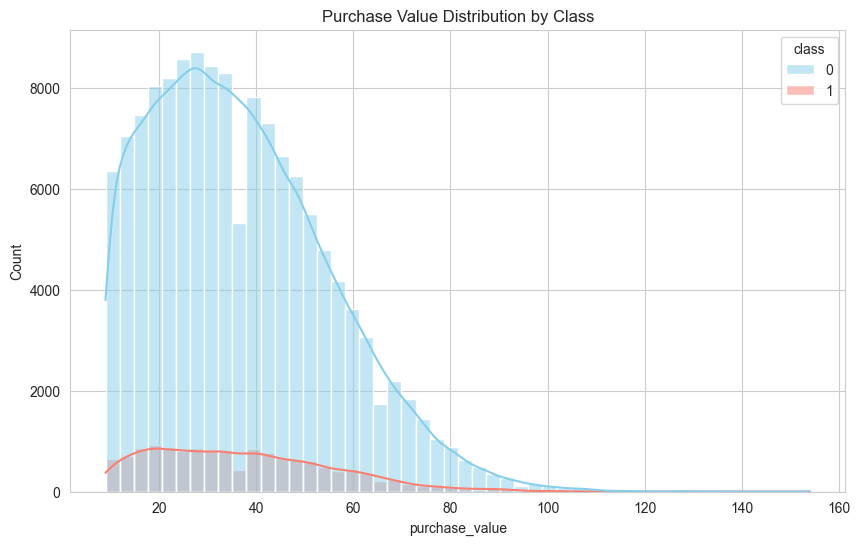

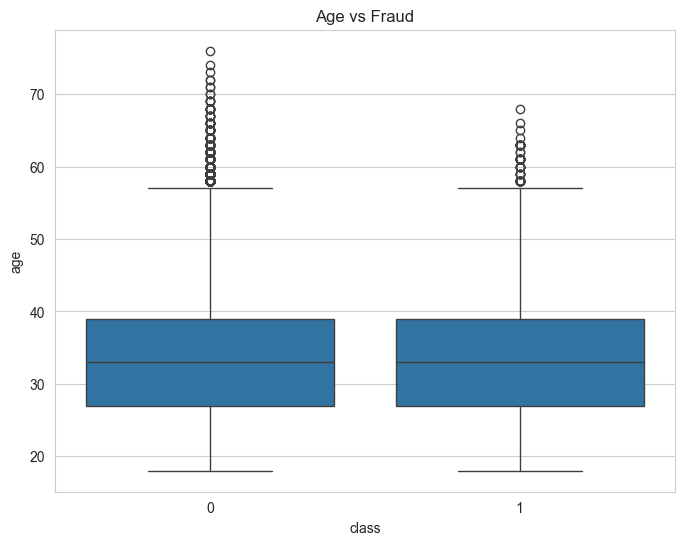

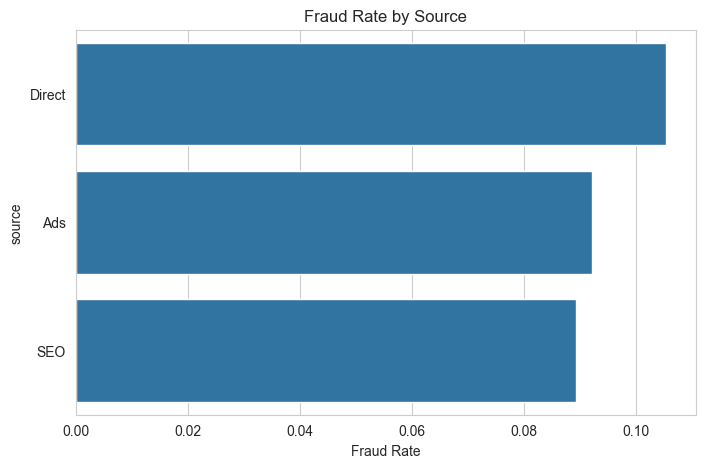

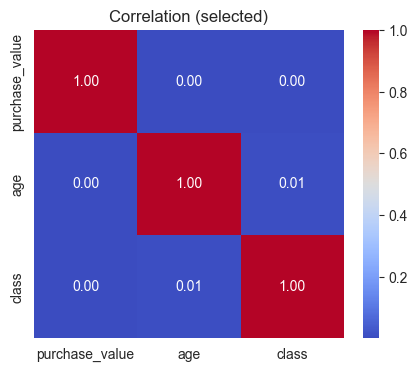

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(data=fraud_df, x='purchase_value', hue='class', bins=50, kde=True, palette=['skyblue', 'salmon'])
plt.title('Purchase Value Distribution by Class')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(data=fraud_df, x='class', y='age')
plt.title('Age vs Fraud')
plt.show()

plt.figure(figsize=(8, 5))
fraud_by_source = fraud_df.groupby('source')['class'].mean().sort_values(ascending=False)
sns.barplot(x=fraud_by_source.values, y=fraud_by_source.index)
plt.title('Fraud Rate by Source')
plt.xlabel('Fraud Rate')
plt.show()

num_cols = ['purchase_value', 'age']
corr = fraud_df[num_cols + ['class']].corr()
plt.figure(figsize=(5, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation (selected)')
plt.show()

## 5. Geolocation: IP to country

Countries added. Unique countries: 182
Unknown country count: 21966


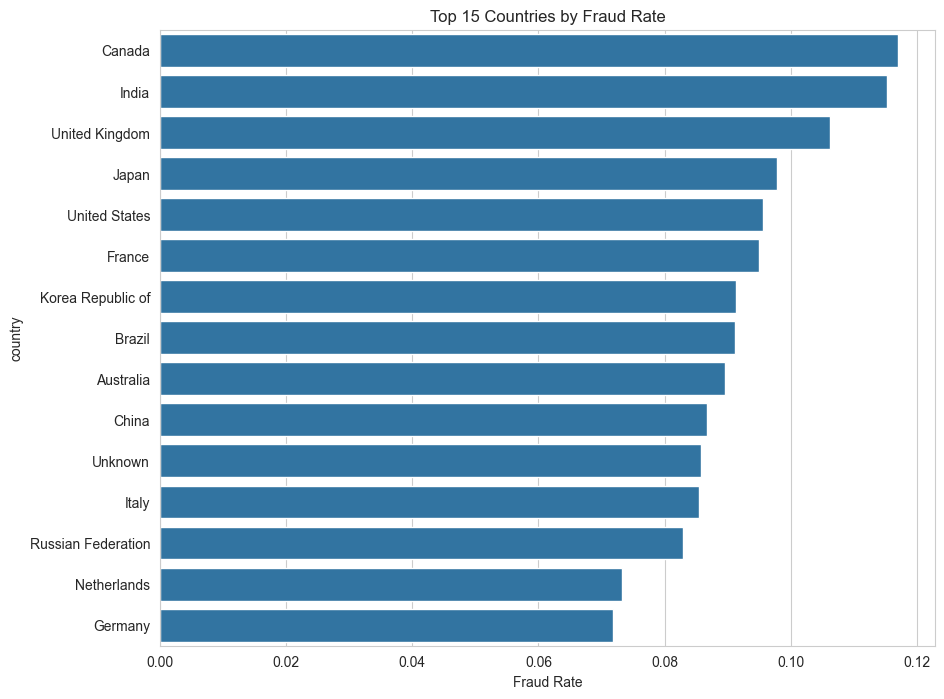

In [16]:
ip_country['lower_bound_ip_address'] = ip_country['lower_bound_ip_address'].astype('int64')
ip_country['upper_bound_ip_address'] = ip_country['upper_bound_ip_address'].astype('int64')

fraud_sorted = fraud_df.sort_values('ip_address')
ip_sorted = ip_country.sort_values('lower_bound_ip_address')

merged = pd.merge_asof(
    fraud_sorted,
    ip_sorted,
    left_on='ip_address',
    right_on='lower_bound_ip_address',
    direction='backward'
)

merged['country'] = np.where(
    merged['ip_address'] <= merged['upper_bound_ip_address'],
    merged['country'],
    'Unknown'
)

fraud_df = merged.sort_index()
print('Countries added. Unique countries:', fraud_df['country'].nunique())
print('Unknown country count:', (fraud_df['country'] == 'Unknown').sum())

top_countries = fraud_df['country'].value_counts().head(15).index
fraud_by_country = (
    fraud_df[fraud_df['country'].isin(top_countries)]
    .groupby('country')['class']
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10, 8))
sns.barplot(x=fraud_by_country.values, y=fraud_by_country.index)
plt.title('Top 15 Countries by Fraud Rate')
plt.xlabel('Fraud Rate')
plt.show()

## 6. Feature engineering
- time_since_signup (hours)
- hour_of_day, day_of_week
- transactions_per_device

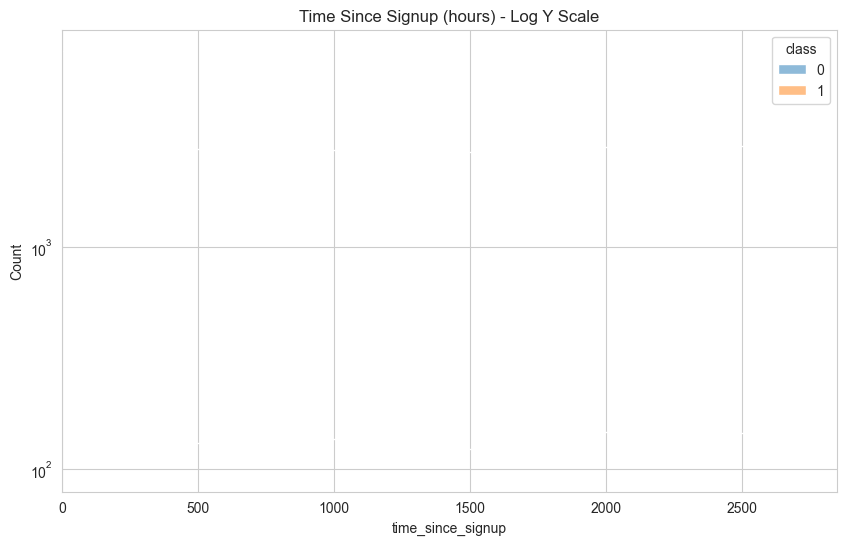

In [18]:
fraud_df['time_since_signup'] = (
    fraud_df['purchase_time'] - fraud_df['signup_time']
).dt.total_seconds() / 3600
fraud_df['hour_of_day'] = fraud_df['purchase_time'].dt.hour
fraud_df['day_of_week'] = fraud_df['purchase_time'].dt.dayofweek
fraud_df['transactions_per_device'] = fraud_df.groupby('device_id')['user_id'].transform('count')

plt.figure(figsize=(10, 6))
sns.histplot(
    data=fraud_df,
    x='time_since_signup',
    hue='class',
    bins=50,
    log_scale=(False, True)
)
plt.title('Time Since Signup (hours) - Log Y Scale')
plt.xlim(0, fraud_df['time_since_signup'].quantile(0.99))
plt.show()

## 7. Save processed data

In [17]:
fraud_df.to_csv(PROCESSED_PATH + 'fraud_processed.csv', index=False)
print('Saved to data/processed/fraud_processed.csv')
print('Next: handle imbalance during modeling (e.g., SMOTE or class weights on train only).')

Saved to data/processed/fraud_processed.csv
Next: handle imbalance during modeling (e.g., SMOTE or class weights on train only).


## Geolocation Integration: IP to Country Mapping

We perform a range-based merge using `pd.merge_asof` to map each transaction's IP address to its country.
This is critical for detecting fraud patterns from high-risk regions.

In [18]:
import os
import pandas as pd
import numpy as np

# Use project-level RAW_PATH for correct relative path from notebooks/
fraud_path = os.path.join(RAW_PATH, 'Fraud_Data.csv')
ip_map_path = os.path.join(RAW_PATH, 'IpAddress_to_Country.csv')

# Load datasets
fraud_df = pd.read_csv(fraud_path, parse_dates=['signup_time', 'purchase_time'])
ip_country = pd.read_csv(ip_map_path)

print("Fraud_Data shape:", fraud_df.shape)
print("IpAddress_to_Country shape:", ip_country.shape)

Fraud_Data shape: (151112, 11)
IpAddress_to_Country shape: (138846, 3)


In [19]:
# Convert ip_address to int64
fraud_df['ip_address'] = fraud_df['ip_address'].astype('int64')

# Convert bounds to int64
ip_country['lower_bound_ip_address'] = ip_country['lower_bound_ip_address'].astype('int64')
ip_country['upper_bound_ip_address'] = ip_country['upper_bound_ip_address'].astype('int64')

# Sort both DataFrames
fraud_sorted = fraud_df.sort_values('ip_address')
ip_sorted = ip_country.sort_values('lower_bound_ip_address')

In [20]:
# Merge using backward lookup
merged = pd.merge_asof(
    fraud_sorted,
    ip_sorted,
    left_on='ip_address',
    right_on='lower_bound_ip_address',
    direction='backward'
)

# Validate range and assign country
merged['country'] = np.where(
    (merged['ip_address'] >= merged['lower_bound_ip_address']) & 
    (merged['ip_address'] <= merged['upper_bound_ip_address']),
    merged['country'],
    'Unknown'
)

# Restore DataFrame
fraud_df = merged.reset_index(drop=True)

# Results
print(f"Successfully mapped countries: {fraud_df['country'].nunique()} unique countries")
print(f"Transactions with 'Unknown' country: {(fraud_df['country'] == 'Unknown').sum()} ({(fraud_df['country'] == 'Unknown').mean()*100:.2f}%)")

Successfully mapped countries: 182 unique countries
Transactions with 'Unknown' country: 21966 (14.54%)


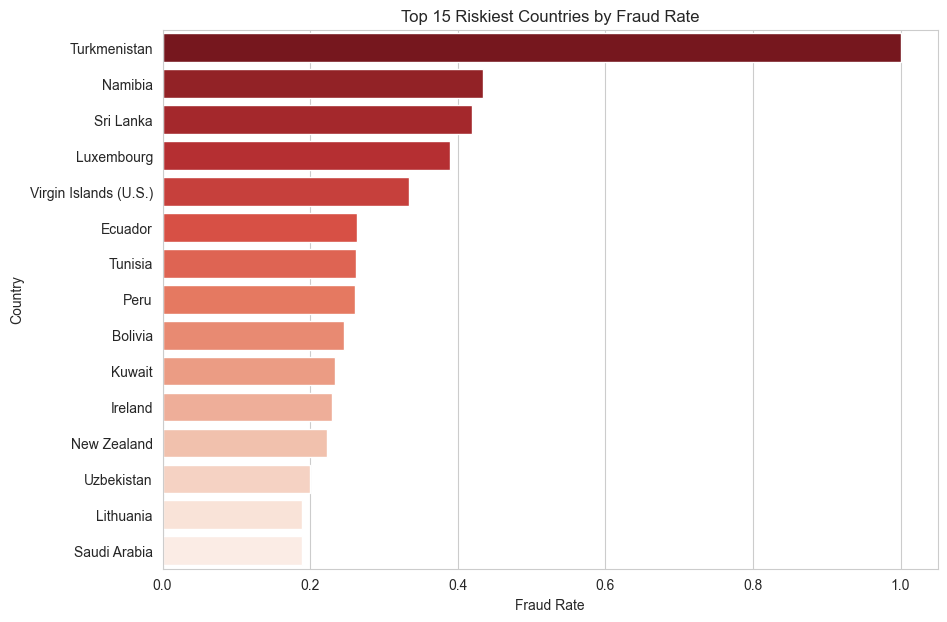

Top 10 countries by transaction volume:
country
United States        58049
Unknown              21966
China                12038
Japan                 7306
United Kingdom        4490
Korea Republic of     4162
Germany               3646
France                3161
Canada                2975
Brazil                2961
Name: count, dtype: int64


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top 15 countries by fraud rate
country_fraud_rate = fraud_df[fraud_df['country'] != 'Unknown'].groupby('country')['class'].mean().sort_values(ascending=False)
top_15_risky = country_fraud_rate.head(15)

plt.figure(figsize=(10, 7))
sns.barplot(x=top_15_risky.values, y=top_15_risky.index, palette='Reds_r')
plt.title('Top 15 Riskiest Countries by Fraud Rate')
plt.xlabel('Fraud Rate')
plt.ylabel('Country')
plt.show()

# Also show top countries by volume
top_volume = fraud_df['country'].value_counts().head(10)
print("Top 10 countries by transaction volume:")
print(top_volume)